## Comparison of convergence-rate of Double Oracle and Expected Regret Minimization algorithms
### Used for finding a Mixed Nash Equilibrium in a continuous game (both players have inifinite action spaces (hypercubes))

In [ ]:
import matplotlib.pyplot as plt
from game import *

### The Townsend function and the game based on it

often used for benchmarking optimization algorithms
https://en.wikipedia.org/wiki/Test_functions_for_optimization

$ f(x,y) = -[cos((x-0.1)y)]^2 - x sin(3x+y)$

where 

$
{\displaystyle -2.25\leq x\leq 2.25},
{\displaystyle -2.5\leq y\leq 1.75}
$

#### That means:
- Player A has an action space defined as the square [-2.25, 2.25]
- Player B has an action space defined as the square [-2.5, 1.75]
- Their utility gain is $ f(a,b) $

In [2]:
def townsend(x,y):
    term1 = np.power( np.cos( (x-0.1)*y ), 2)
    term2 = x*np.sin( 3*x+y )
    return -term1 -term2

A_bounds = np.array([[-2.25, 2.50]])  #interval (-2.5;2.5) in one dimension only
B_bounds = np.array([[-2.25, 1.75]])  #interval (-2.5;1.75) in one dimension only

game_townsend = Game(A=HyperBlock(A_bounds), B=HyperBlock(B_bounds), u=townsend, name="townsend")


### Setting constants

(Feel free to change!)

$\epsilon = 10^{-6} $

$C = 10^{-11}$ (for ERM only)

$InitialStrategy$ is either $bounds$ or $random$. Choosing $bounds$ for better reproducibility

In [3]:
eps = 1e-12
C   = 1e-23
init_algorithm = "bounds"
maxiter=20

### Solving the game by the Double Oracle algorithm
implemented in double_oracle.py

Algorithm is explained, for example, here:
https://arxiv.org/abs/2009.12185

1. for $t = 1,...$

$\;\;\;\;(a)$ find NE $\;(p_t^*,q_t^*)$ of subgame $(as_t,bs_t,u)$

$\;\;\;\;(b)\; a \leftarrow BestResponse(bs_t, q_t^*)$; $b \leftarrow BestResponse(as_t, p_t^*)$

$\;\;\;\;(c)\; as_{t+1} \leftarrow as_{t} \cup \{a\}$; $bs_{t+1} \leftarrow bs_{t} \cup \{b\}$

$\;\;\;\;(d)\;$ if $(u(p_t^*, b))-(u(a,q_t^*)) \le \epsilon$:

$\;\;\;\;\;\;\;\;$ Return $(p_t^*,q_t^*)$


In [4]:
from double_oracle import *
xs, p, ys, q, value_lbs, value_ubs, brs = double_oracle(game=game_townsend, init_algorithm=init_algorithm, maxiter=maxiter, eps=eps)
DO_outcome = (xs, p, ys, q, value_lbs, value_ubs, brs)
print("Value in Nash equilibrium: ", value_lbs[-1])


itr:  0
itr:  1
itr:  2
itr:  3
itr:  4
itr:  5
itr:  6
itr:  7
itr:  8
itr:  9
itr:  10
itr:  11
itr:  12
itr:  13
itr:  14
itr:  15
itr:  16


/home/grifon/school/project/ERMvsDO/oracles.py:29: OptimizeWarning: Unrecognized options detected: {'autoscale': True, 'sym_pos': False}. These will be passed to HiGHS verbatim.
  ret = sp.linprog( -function_vector, -boundary_matrix, np.zeros(height), eq_matrix, np.array([1]), bnds, method=lp_solver, options={'autoscale': True, 'sym_pos':False, 'maxiter':int(1e5)})
/home/grifon/school/project/ERMvsDO/oracles.py:31: OptimizeWarning: Unrecognized options detected: {'autoscale': True, 'sym_pos': False}. These will be passed to HiGHS verbatim.
  ret = sp.linprog( function_vector, boundary_matrix, np.zeros(height), eq_matrix, np.array([1]), bnds, method=lp_solver, options={'autoscale': True, 'sym_pos':False, 'maxiter':int(1e5)})


itr:  17
itr:  18
itr:  19
Value in Nash equilibrium:  -0.5579071368481898


### Solving the game by the Expected Regret Minimization algorithm
implemented in erm.py

Algorithm is explained, for example, here:
https://arxiv.org/abs/2307.01689

$\epsilon-$approximate Nash Equilibrium for a zero-sum game

1. $A_0 \leftarrow \{a\}, B_0 \leftarrow \{b\}$, where $a \in A$ and $b \in B$ are arbitrary actions

2. For $t = 1,2,...$

$\;\;\;\;(a)\; (responses_a, \; probabilities_b) \leftarrow Nash(A, bs_{t-1}, \epsilon)$

$\;\;\;\;(b)\; as_t \leftarrow as_{t-1} \cup responses_a $

$\;\;\;\;(c)\; (responses_b, \; probabilities_a) \leftarrow Nash(B, as_{t}, \epsilon)$

$\;\;\;\;(d)\; bs_t \leftarrow bs_{t-1} \cup responses_b $

$\;\;\;\;(e)\;$ if Val $ (as_t,bs_{t-1}) \ge $Val $ (as_{t-1},bs_{t-1}) - \epsilon\;\; $ or Val $ (as_t,bs_t) \le $ Val $ (as_t,bs_{t-1}) + \epsilon: $

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ Return $ \;\; (as_t, bs_t) $

NASH:

$\epsilon-$ Nash Equilibrium for a half-infinite zero-sum game

1. $T \leftarrow \left\lceil {C log|A|}\over{\epsilon^2} \right\rceil $ ; $\eta \leftarrow \sqrt{log|A| \over 2T}$

2. $p^1 = (p_1^1, ... , p_n^1)$ is a uniform distribution over $as$

3. $b_1 \leftarrow BestResponse(as, p_1)$

4. for $t=2,...,T $

$\;\;\;\;(a)\;$ for $i = 1,...,N$
:$\;\;\;\;\;$ $ p_i^t $=$ {p_i^{t-1} exp(\eta \; u(a_i,b_{t-1}))} / Z^t $

$\;\;\;\;\;\;\;\;\;\;$ where: 

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;Z^t = \sum_{j=1}^{n}{p_j^{t-1} exp(\eta \; u(a_j,b_{t-1}))}$

$\;\;\;\;(b)\; b_t \leftarrow BestResponse(as, p_t)$

5. Return $(bs, avg(p))$


In [5]:
from erm import *
xs, p, ys, q, value_lbs, value_ubs, brs, as_lens, bs_lens = eps_nash_erm(game=game_townsend, C=C, init_algorithm=init_algorithm, maxiter=maxiter, eps=eps)
ERM_outcome = (xs, p, ys, q, value_lbs, value_ubs, brs, as_lens, bs_lens)
print("Value in Nash equilibrium: ", value_lbs[-1])

iter  0
T =  7
T =  22
iter  1
T =  32
T =  37
iter  2
T =  41
T =  44
iter  3
T =  47
T =  49
iter  4
T =  50
T =  52
Value in Nash equilibrium:  -0.5496690591105959


### Plot convergence

- how the algorithms converges per $BestResponse$ Oracle calls
- how the algorithms converges per iteration

Note, that while ERM converges to the final value much faster in terms of iterations, it is the opposite, when it comes to the number of Oracle calls.

Therefore, there is some kind of trade-off.

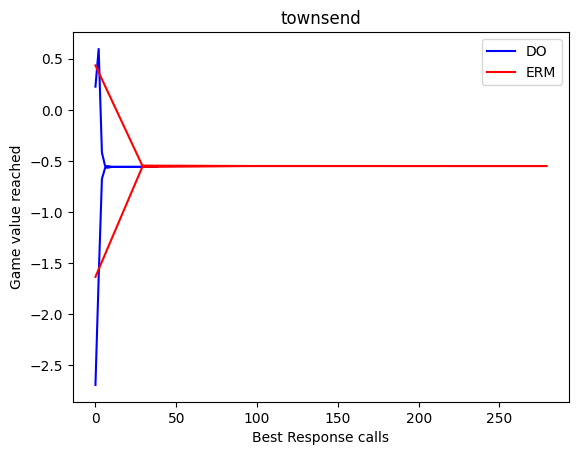

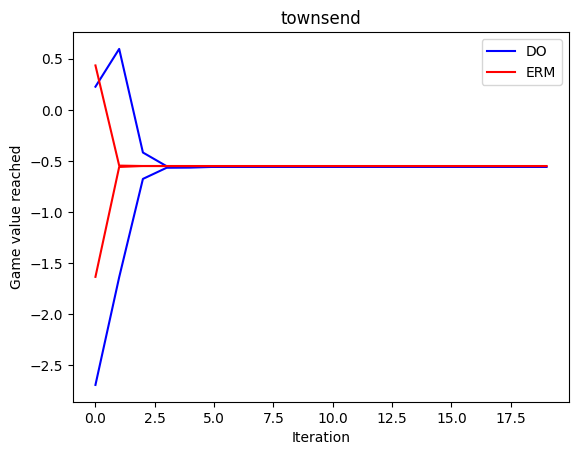

<Figure size 640x480 with 0 Axes>

In [6]:
from plotting import *
plot_convergence(DO_outcome[4], DO_outcome[5], DO_outcome[6], ERM_outcome[4],ERM_outcome[5], ERM_outcome[6], game_townsend.name, display=True)

### Plot complexity of the Expected Regret Minimization algorithm
how the fast does rise the 

- number of considered actions (per iteration)
- number of $BestResponse$ calls (per iteration)

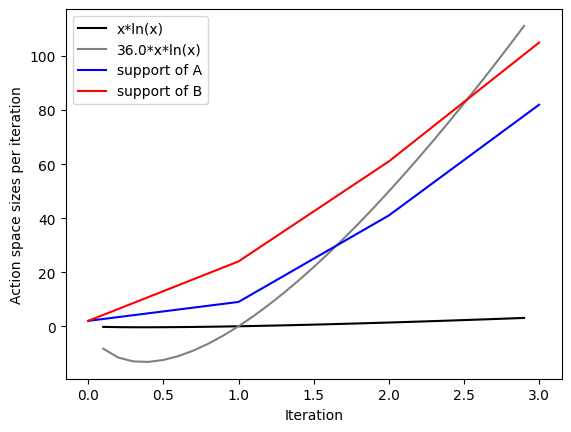

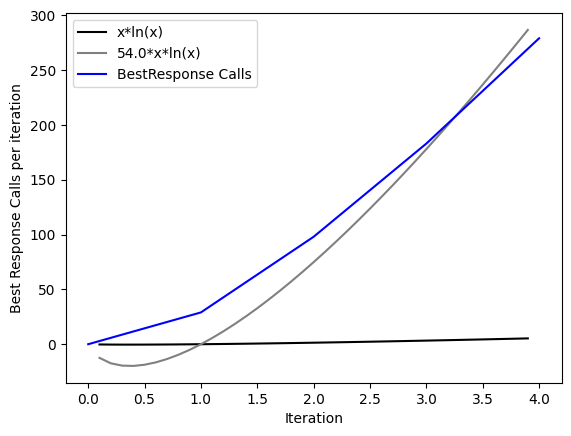

<Figure size 640x480 with 0 Axes>

In [7]:
plot_complexity(as_lens, bs_lens, ERM_outcome[6], game_townsend.name, display=True)